# OTA Room Price Analysis

### Execute the cell below once to turn off debugging

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

## Initialize OTA Scraper Class
Required to extract the data from the Wrangler

In [10]:
import sys
sys.path.insert(1, '../../lib/wrangler')
import otaWebScraper as otaws
import clean as clean
import enrich as enrich
import datetime

dataDirPath="../../data/hospitality/bookings/scraper/"

if debug:
    import importlib
    otaws = importlib.reload(otaws)
    clean = importlib.reload(clean)
    enrich = importlib.reload(enrich)

_dataName = "booking_search_data"

clsScraper = otaws.OTAWebScraper(name=_dataName)
clsCleaner = clean.DataClensing(name=_dataName)
clsEnrich = enrich.DataEnrichment(name=_dataName)

All packages in OTAWebScraper loaded successfully!
All packages in DataClensing loaded successfully!
All packages in OTAWebScraper loaded successfully!
Initialing OTAWebScraper class for  booking_search_data
Initialing DataEnrichment class for  booking_search_data
Initialing DataEnrichment class for  booking_search_data


## Load the data

In [11]:
#../../data/hospitality/bookings/scraper/rates/2022-9-7-9-0/
#dirPath = _current_search_data_dir
dirPath = dataDirPath+"rates/2022-9-7-9-0/"
removed_files = clsScraper.remove_empty_files(dirPath)
if len(removed_files) > 0:
    print("%d files removed" %len(removed_files))
kwargs = {"columns" : ["search_datetime",
                       "checkin_date",
                       "propery_name",
                       "room_type",
                       "room_rate",
                       "review_score",
                       "destination_id",
                       "location",
                       "other"]}

rates_df = clsScraper.read_folder_csv_to_df(dirPath, **kwargs)
dtype_dict = {"search_datetime": "datetime64[ns]",
              "checkin_date": "datetime64[D]",
              "propery_name": "string",
              "room_type": "string",
              "room_rate": "string",
              "review_score": "float64",
              "destination_id": "string",
              "location": "string",
              "other" : "string"
             }
''' set the desired data types '''
rates_df = rates_df.astype(dtype_dict)
#rates_df.info()

In [5]:
''' drop duplicate rows '''
import pandas as pd

#print(rates_df.shape)

_distinct_df = pd.DataFrame()
_distinct_df = clsCleaner.drop_duplicates(rates_df)
#print(_distinct_df.shape)
''' round search datetime to nearest 30 min'''
_distinct_df['search_datetime']=_distinct_df['search_datetime'].dt.round('30min')

## Augment with datetime columns

In [6]:
''' Augment the DateTime columns with listed new columns '''
_dict_col_to_aug = {"DateTime" :   # type of datetime columns to augment the dataframe
                    ["YYYY",       # 4 digit year (int)
                     "DD",         # day as 1 digit and 2 digit if abbreviation = true
                     "MM",         # month as 1 digit and 2 digit if abbreviation = true
                     "MMM",        # month as name or 3 letters if abbreviation = True
                     "DOW",        # day-of-week name or 3 letter if abbreviation = True
                     "MMM-DD",     # three letter two digit month and two digit day (e.g. [09]Sep-10)
                     "HH-mm",      # two digit hour and minute
                    ]
                   }
_kwargs = {"dt_col_name" : "search_datetime",    # identifies the datetime column in the dataframe
           "pad_lead_zeros" : True,   # truncates the string to give 3 character names for year, month, dow
           "abbreviate" : True,
           "sorted_by" : ["YYYY","MM","DD"]
          }
_enriched_df = clsEnrich.get_enriched_data(_distinct_df,
                                           col_augment_dict = _dict_col_to_aug,
                                           **_kwargs
                                          )
_aug_cols = _dict_col_to_aug["DateTime"]
_distinct_df[_aug_cols] = _enriched_df[_aug_cols]

''' sort by date '''
_distinct_df = _distinct_df.sort_values(by=["YYYY","MM","DD"],kind='quicksort')
#print(_distinct_df.head())
print("\nEnrichment Complete!")
print(_distinct_df.shape)
print(_distinct_df.info())

Columns to augment to dataframe:
 {'DateTime': ['YYYY', 'DD', 'MM', 'MMM', 'DOW', 'MMM-DD', 'HH-mm']}

Enrichment Complete!
(2258, 16)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2258 entries, 0 to 2257
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   search_datetime  2258 non-null   datetime64[ns]
 1   checkin_date     2258 non-null   datetime64[ns]
 2   propery_name     2258 non-null   string        
 3   room_type        2258 non-null   string        
 4   room_rate        2258 non-null   string        
 5   review_score     2258 non-null   float64       
 6   destination_id   2258 non-null   string        
 7   location         2258 non-null   string        
 8   other            2258 non-null   string        
 9   YYYY             2258 non-null   int64         
 10  DD               2258 non-null   object        
 11  MM               2258 non-null   object        
 12  MMM        

In [9]:
_distinct_df['room_rate'].unique()
#_distinct_df['search_datetime'].unique()

<StringArray>
[  'US$629',   'US$409',   'US$659',   'US$599',   'US$589',   'US$524',
   'US$665',   'US$749',   'US$469',   'US$559',
 ...
 'US$2,960',   'US$223',    'US$40',   'US$232',   'US$280', 'US$1,051',
   'US$430',   'US$112',   'US$300',   'US$310']
Length: 451, dtype: string

* [Consider clustering with SOM](https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering/notebook)
* [Time-series segmentation](https://www.kaggle.com/code/zonnalobo/timeseries-segmentation-and-forecasting/notebook)

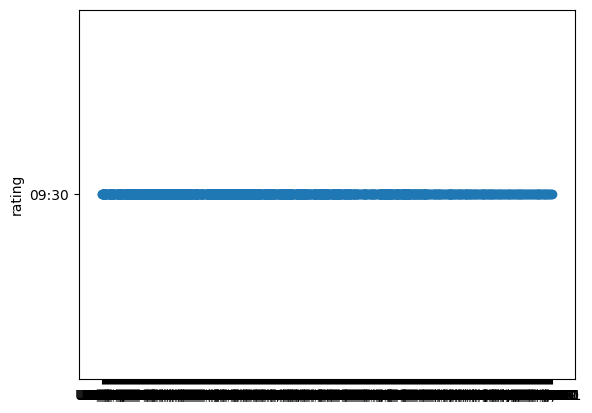

In [8]:
import matplotlib.pyplot as plt

plt.scatter(_distinct_df['room_rate'],_distinct_df['HH-mm'])
plt.ylabel('rating')
plt.show()